In [1]:
import torch
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import timm
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader, random_split
import torch.nn.functional as F
from torchvision import models

import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, confusion_matrix ,roc_curve
import seaborn as sns

In [2]:
chunk_size = 15

# List of Parquet file paths
file_paths = [
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet',
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet',
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet'
]

# Initialize an empty list to store dataframes
dfs = []

# Loop through each file path
for file_path in file_paths:
    # Create a Parquet file reader object
    parquet_file = pq.ParquetFile(file_path)
    
    # Determine the total number of rows in the file
    total_rows = parquet_file.metadata.num_rows
    
    # Calculate the number of chunks
    num_chunks = total_rows // chunk_size + (1 if total_rows % chunk_size else 0)
    
    # Loop over the file in chunks
    for chunk_index in range(num_chunks):
        # Read a chunk of rows from the file
        chunk = parquet_file.read_row_group(chunk_index, columns=None)
        df = chunk.to_pandas()
        
        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all the DataFrames into a single DataFrame
data = pd.concat(dfs, ignore_index=True)

In [3]:
def to_3d(arr):
    vishak=[]
    for i in range (0,3):
        vis=np.stack(np.stack(arr)[i],axis=-1)
        vishak.append(vis)
    vishak=np.array(vishak)
    return vishak

In [4]:
data["X_jets"]  = data["X_jets"].apply(to_3d)

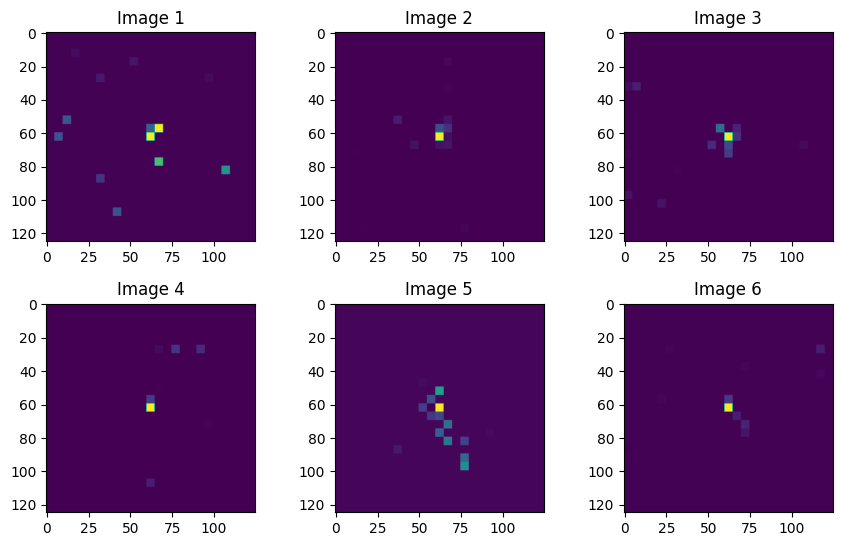

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Loop over the axes and image ids, and plot each image on a separate subplot
for i, ax in enumerate(axes.flatten()):
    image = data['X_jets'][i][2,:,:]
    ax.imshow(image)
    ax.set_title(f'Image {i+1}')
    
# Adjust spacing between subplots
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)

# Show the plot
plt.show()

In [6]:
data.columns

Index(['X_jets', 'pt', 'm0', 'y'], dtype='object')

In [7]:
# data['y']

In [8]:
class task2Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Assuming 'X_jets' column contains paths to images or actual image data
        X = self.dataframe.iloc[idx]['X_jets']
        mean = X.mean(axis=(0, 1, 2), keepdims=True)
        std = X.std(axis=(0, 1, 2), keepdims=True)

        # Normalize each channel separately
        X = (X - mean) / std
        y = self.dataframe.iloc[idx]['y']
        
        if self.transform:
            X = self.transform(X)
        
        # Convert X and y to PyTorch tensors
        X_tensor = torch.tensor(X, dtype=torch.float)
        y_tensor = torch.tensor(y, dtype=torch.long)

        return X_tensor, y_tensor


In [9]:
jet_dataset = task2Dataset(dataframe=data)


train_dataset, val_dataset = train_test_split(jet_dataset, test_size=0.2, random_state=42)


train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

In [10]:
next(iter(train_loader))[0].shape

torch.Size([256, 3, 125, 125])

In [11]:
class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(CustomEfficientNet, self).__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=pretrained, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize your model
model = CustomEfficientNet(num_classes=2, pretrained=True)
print(model)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

CustomEfficientNet(
  (model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_si

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [13]:
num_epochs = 20
train_losses, val_losses, val_accuracies = [], [], []
best_loss = 100000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train] Loss: 0.0000", leave=False)
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        train_bar.set_description(f"Epoch {epoch+1}/{num_epochs} [Train] Loss: {loss.item():.4f}")
    
    #scheduler.step()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val] Loss: 0.0000, Acc: 0.0000", leave=True)
    
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            
            
            val_bar.set_description(f"Epoch {epoch+1}/{num_epochs} [Val] Loss: {loss.item():.4f}, Acc: {correct_predictions/total_predictions:.4f}")
    
    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    epoch_val_accuracy = correct_predictions / total_predictions
    best_loss = min(epoch_val_loss , best_loss)
    val_accuracies.append(epoch_val_accuracy)
    
    if(epoch_val_loss== best_loss):
        
            model_path = f"model_weights_{epoch}.pth"
            torch.save(model.state_dict(), model_path)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")


Epoch 1/20 [Val] Loss: 3.3815, Acc: 0.5818: 100%|██████████| 59/59 [00:01<00:00, 58.59it/s]


Epoch 1/20, Train Loss: 2.3755, Val Loss: 1.9780, Val Accuracy: 0.5818


Epoch 2/20 [Val] Loss: 2.3931, Acc: 0.5883: 100%|██████████| 59/59 [00:00<00:00, 68.17it/s]


Epoch 2/20, Train Loss: 0.6187, Val Loss: 2.0196, Val Accuracy: 0.5883


Epoch 3/20 [Val] Loss: 3.2673, Acc: 0.5953: 100%|██████████| 59/59 [00:00<00:00, 67.72it/s]


Epoch 3/20, Train Loss: 0.2260, Val Loss: 2.0355, Val Accuracy: 0.5953


Epoch 4/20 [Val] Loss: 1.1770, Acc: 0.5915: 100%|██████████| 59/59 [00:00<00:00, 67.56it/s]


Epoch 4/20, Train Loss: 0.1320, Val Loss: 2.1180, Val Accuracy: 0.5915


Epoch 5/20 [Val] Loss: 0.1135, Acc: 0.5974: 100%|██████████| 59/59 [00:00<00:00, 68.19it/s]


Epoch 5/20, Train Loss: 0.1207, Val Loss: 2.1878, Val Accuracy: 0.5974


Epoch 6/20 [Val] Loss: 0.4347, Acc: 0.6012: 100%|██████████| 59/59 [00:00<00:00, 67.72it/s]


Epoch 6/20, Train Loss: 0.0737, Val Loss: 2.1002, Val Accuracy: 0.6012


Epoch 7/20 [Val] Loss: 1.1005, Acc: 0.5985: 100%|██████████| 59/59 [00:00<00:00, 68.14it/s]


Epoch 7/20, Train Loss: 0.0376, Val Loss: 2.0010, Val Accuracy: 0.5985


Epoch 8/20 [Val] Loss: 1.6040, Acc: 0.6050: 100%|██████████| 59/59 [00:00<00:00, 69.01it/s]


Epoch 8/20, Train Loss: 0.0567, Val Loss: 2.1770, Val Accuracy: 0.6050


Epoch 9/20 [Val] Loss: 0.4433, Acc: 0.5926: 100%|██████████| 59/59 [00:00<00:00, 67.52it/s]


Epoch 9/20, Train Loss: 0.0654, Val Loss: 2.2450, Val Accuracy: 0.5926


Epoch 10/20 [Val] Loss: 0.6558, Acc: 0.5872: 100%|██████████| 59/59 [00:00<00:00, 66.93it/s]


Epoch 10/20, Train Loss: 0.0702, Val Loss: 2.1872, Val Accuracy: 0.5872


Epoch 11/20 [Val] Loss: 0.3706, Acc: 0.6060: 100%|██████████| 59/59 [00:00<00:00, 66.38it/s]


Epoch 11/20, Train Loss: 0.0913, Val Loss: 2.2343, Val Accuracy: 0.6060


Epoch 12/20 [Val] Loss: 0.1197, Acc: 0.6006: 100%|██████████| 59/59 [00:00<00:00, 67.78it/s]


Epoch 12/20, Train Loss: 0.0481, Val Loss: 2.1802, Val Accuracy: 0.6006


Epoch 13/20 [Val] Loss: 0.7628, Acc: 0.5926: 100%|██████████| 59/59 [00:00<00:00, 68.17it/s]


Epoch 13/20, Train Loss: 0.0600, Val Loss: 2.7413, Val Accuracy: 0.5926


Epoch 14/20 [Val] Loss: 0.1900, Acc: 0.6109: 100%|██████████| 59/59 [00:00<00:00, 68.71it/s]


Epoch 14/20, Train Loss: 0.0849, Val Loss: 2.2256, Val Accuracy: 0.6109


Epoch 15/20 [Val] Loss: 0.0440, Acc: 0.6163: 100%|██████████| 59/59 [00:00<00:00, 68.66it/s]


Epoch 15/20, Train Loss: 0.0594, Val Loss: 2.2129, Val Accuracy: 0.6163


Epoch 16/20 [Val] Loss: 0.0592, Acc: 0.5974: 100%|██████████| 59/59 [00:00<00:00, 68.31it/s]


Epoch 16/20, Train Loss: 0.0304, Val Loss: 2.2940, Val Accuracy: 0.5974


Epoch 17/20 [Val] Loss: 0.2811, Acc: 0.6184: 100%|██████████| 59/59 [00:00<00:00, 69.15it/s]


Epoch 17/20, Train Loss: 0.0516, Val Loss: 2.4111, Val Accuracy: 0.6184


Epoch 18/20 [Val] Loss: 0.0082, Acc: 0.6270: 100%|██████████| 59/59 [00:00<00:00, 68.51it/s]


Epoch 18/20, Train Loss: 0.0325, Val Loss: 2.3462, Val Accuracy: 0.6270


Epoch 19/20 [Val] Loss: 0.0239, Acc: 0.6044: 100%|██████████| 59/59 [00:00<00:00, 68.65it/s]


Epoch 19/20, Train Loss: 0.0447, Val Loss: 2.2291, Val Accuracy: 0.6044


Epoch 20/20 [Val] Loss: 1.3777, Acc: 0.6184: 100%|██████████| 59/59 [00:00<00:00, 68.18it/s]

Epoch 20/20, Train Loss: 0.0789, Val Loss: 2.4707, Val Accuracy: 0.6184


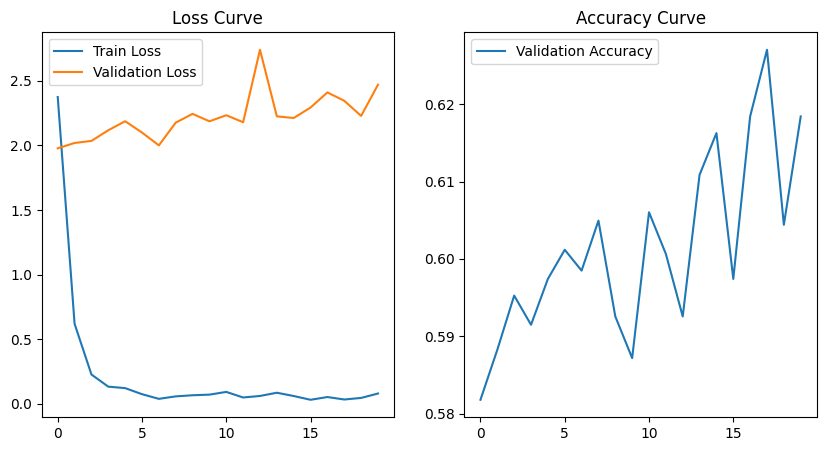

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()
